## Sensitivity Analysis for Sumo model
### Steps followed
1. [Import the necessary libraries to the notebook](#Import_library)
2. [Initialize and load the Sumo model by providing the path and license file](#Initialize)
3. [Define and setup the input factors](#setup)
4. [Conduct the sensitivity analysis](#sensitivity)
5. [Post processing and screening of influential factors](#postprocess)

### <a id=import_library></a> Import libraries

In [2]:
from dynamita.sumo import *
import numpy as np
import time
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import stats   

In [3]:
from SALib.sample import morris
from SALib.analyze import morris as mr
import random
import seaborn as sns

In [4]:
%matplotlib inline

### <a id=Initialize></a> Initialize and load the Sumo model

In [5]:
sumo = Sumo(sumoPath="C:/Users/zeru/AppData/Local/Dynamita/Sumo16", licenseFile=r"networklicense.sumolic")

License OK...


In [428]:
def datacomm_callback(sumo):
    t.append(sumo.core.csumo_var_get_time_double(sumo.handle))
        
    for i in range(6):
        snhx[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, snhx_pos, i))
        sno2[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, sno2_pos, i))
        sno3[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, sno3_pos, i))
        xtss[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, xtss_pos, i))
        xoho[i].append(sumo.core.csumo_var_get_pvtarray_pos(sumo.handle, xoho_pos, i))
       
    return 0

In [390]:
def loadModel():
    sumo.unload_model()
    if not sumo.load_model('GSBR011518.sumo'):
        print ('Model successfuly loaded!')
        sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize.scs;')
        sumo.register_datacomm_callback(datacomm_callback)

In [448]:
def getVar():
    
    snhx_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNHx')
    sno2_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNO2')
    sno3_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__SNO3')
    xtss_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__XTSS')
    xoho_pos = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__XOHO')
    
    #KNHx_AOB_pos2 = sumo.core.csumo_model_get_variable_info_pos(sumo.handle, b'Sumo__Plant__GranularSBR__KNHx_AOB')
    #sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize.scs;')
    return (snhx_pos, sno2_pos, sno3_pos, xtss_pos, xoho_pos)
    #print(KNHx_AOB_pos)
    #print(KNHx_AOB_pos2)

### Test run the Sumo model

In [486]:
#Load and initialize the model first
loadModel()
snhx_pos, sno2_pos, sno3_pos, xtss_pos, xoho_pos=getVar()
print(snhx_pos, sno2_pos, sno3_pos, xtss_pos, xoho_pos)

Model successfuly loaded!
86 87 88 716 78


In [484]:
%%time
stop_t=10*24*3600*1000
dataComm = 180000
sumo.set_stopTime(stop_t)
sumo.set_dataComm(dataComm)
snh={}
#sumo.core.csumo_command_send(sumo.handle, b'execute script_Initialize.scs;')
#command = 'set Sumo__Plant__GranularSBR__KNHx_AOB 0.2 0.2 0.2 0.2 0.2 0.2 ;'
#sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
#sumo.core.csumo_command_send(sumo.handle, b'maptoic;')
for i in range(2):
    t = []
    snhx=[[] for i in range(6)]
    sno2=[[] for i in range(6)]
    sno3=[[] for i in range(6)]
    xoho=[[] for i in range(6)]
    xtss=[[] for i in range(6)]
    sumo.run_model()

    while not sumo.simulation_finished:
        time.sleep(0.01)
    snh[i]=snhx

Wall time: 48.3 s


In [361]:
titles=["Bulk", "Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5"]
data_dict = dict(zip(titles,snhx))
dframe = pd.DataFrame(data_dict, index=t)

In [ ]:
dframe.head(10)

**Plot the results**

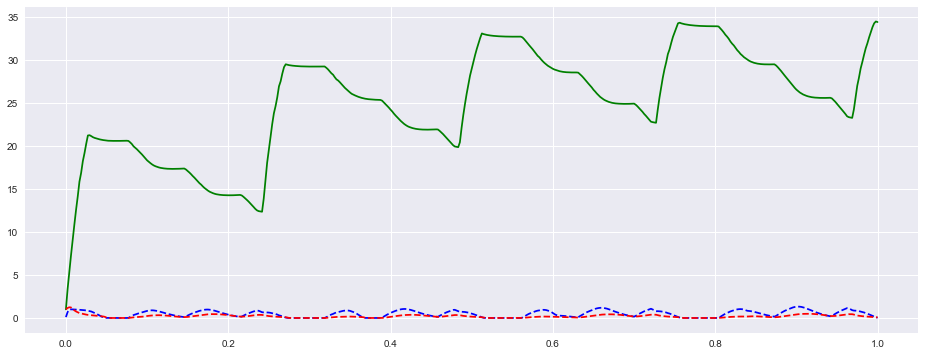

In [485]:
sns.set()
_ = plt.figure(figsize=(16,6))
plt.plot(t,snhx[0], 'g')
plt.plot(t,sno2[0], 'b--')
plt.plot(t,sno3[0], 'r--')

In [457]:
print((xoho[1][0:10]))

[46170.70086209221, 46301.08671797208, 46467.440077213956, 46647.687593123424, 46819.795990866456, 46999.735238118694, 47163.03111086381, 47269.42286224966, 47374.942453496, 47462.27106739096]


In [454]:
y1=xoho[1][0:10]
print((xoho[1][0:10]))

[46170.70086209221, 46301.17742323119, 46467.6135097779, 46649.4647578086, 46820.20634188776, 46998.16172571457, 47142.236792630094, 47261.88457846688, 47383.584076347644, 47469.5411505864]


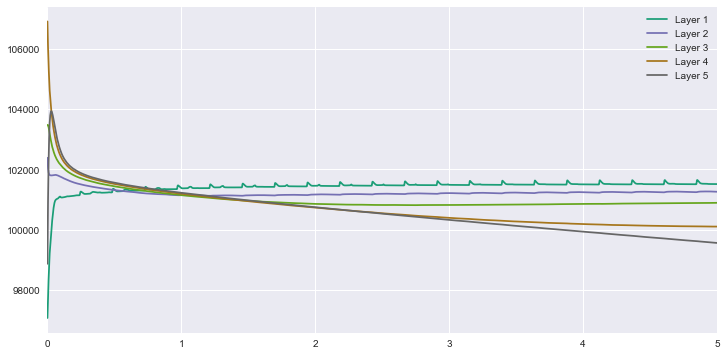

In [483]:
#fig=plt.figure(figsize=(12,6))
xtss_df=pd.DataFrame(np.array(xtss[1:]).T, index=t, columns=titles[1:])
#xtss_df['time']=t
xtss_df.head()
xtss_df.plot(figsize=(12,6), colormap=plt.cm.get_cmap('Dark2'))
#plt.legend(loc="best")

###  <a id=setup></a> Start setting up the sensitivity analysis
#### Start with defining the input factors and their range
21 input factors have been selected to conduct the sensitivity analysis.

In [117]:
%%time
# Start Sensitivity analysis
# Define the model inputs
problem = {
    'num_vars': 23,
    'names': ['KO2_AOB_AS', 'KNHx_AOB_AS', 'muAOB', 'bAOB', 'YAOB', 'KO2_NOB_AS', 'KNO2_NOB_AS', 'muNOB', 'bNOB', 'YNOB', 'KNHx_AMX_AS', 'KNO2_AMX_AS', 'muAMX', 'bAMX', 'YAMX_NO2', 'YAMX_NO3', 'KO2_OHO_AS', 'KNO2_OHO_AS','KNO3_OHO_AS', 'muOHO', 'bOHO', 'YOHO_ox', 'YOHO_anox'],
    'bounds': [[0.1, 3], [0.1, 5], [0.2, 2], [0.01, 0.5], [0.03, 0.3], [0.1, 6], [0.1, 8], [0.1, 5], [0.1, 5], [0.03, 0.3], [0.1, 3], [0.1, 2], [0.01, 0.5], [0.001, 0.05], [0.03, 0.3], [0.03, 0.3], [0.05, 0.5], [0.1, 1], [0.1, 1], [0.1, 8], [0.01, 0.5], [0.1, 0.99],[0.1, 0.99]]
}

# Generate samples
param_values = morris.sample(problem, 20, num_levels=16, grid_jump=6) #, optimal_trajectories= 20)

# Si = morris.analyze(problem, X, Y, conf_level=0.95, print_to_console=True, num_levels=4, grid_jump=2)

Wall time: 9.03 ms


In [ ]:
print(param_values.shape)
params_df=pd.DataFrame(param_values, columns=problem['names'])
params_df.head(10)

### Plot the sample parameters 
The generated samples of the 21 input factors histogram is ploted below. This will help us to visualize how well the samples have been selected from the input space. We should expect approximately a uniform distribution otherwise we have to  re-generate the samples above until we are satisfied.

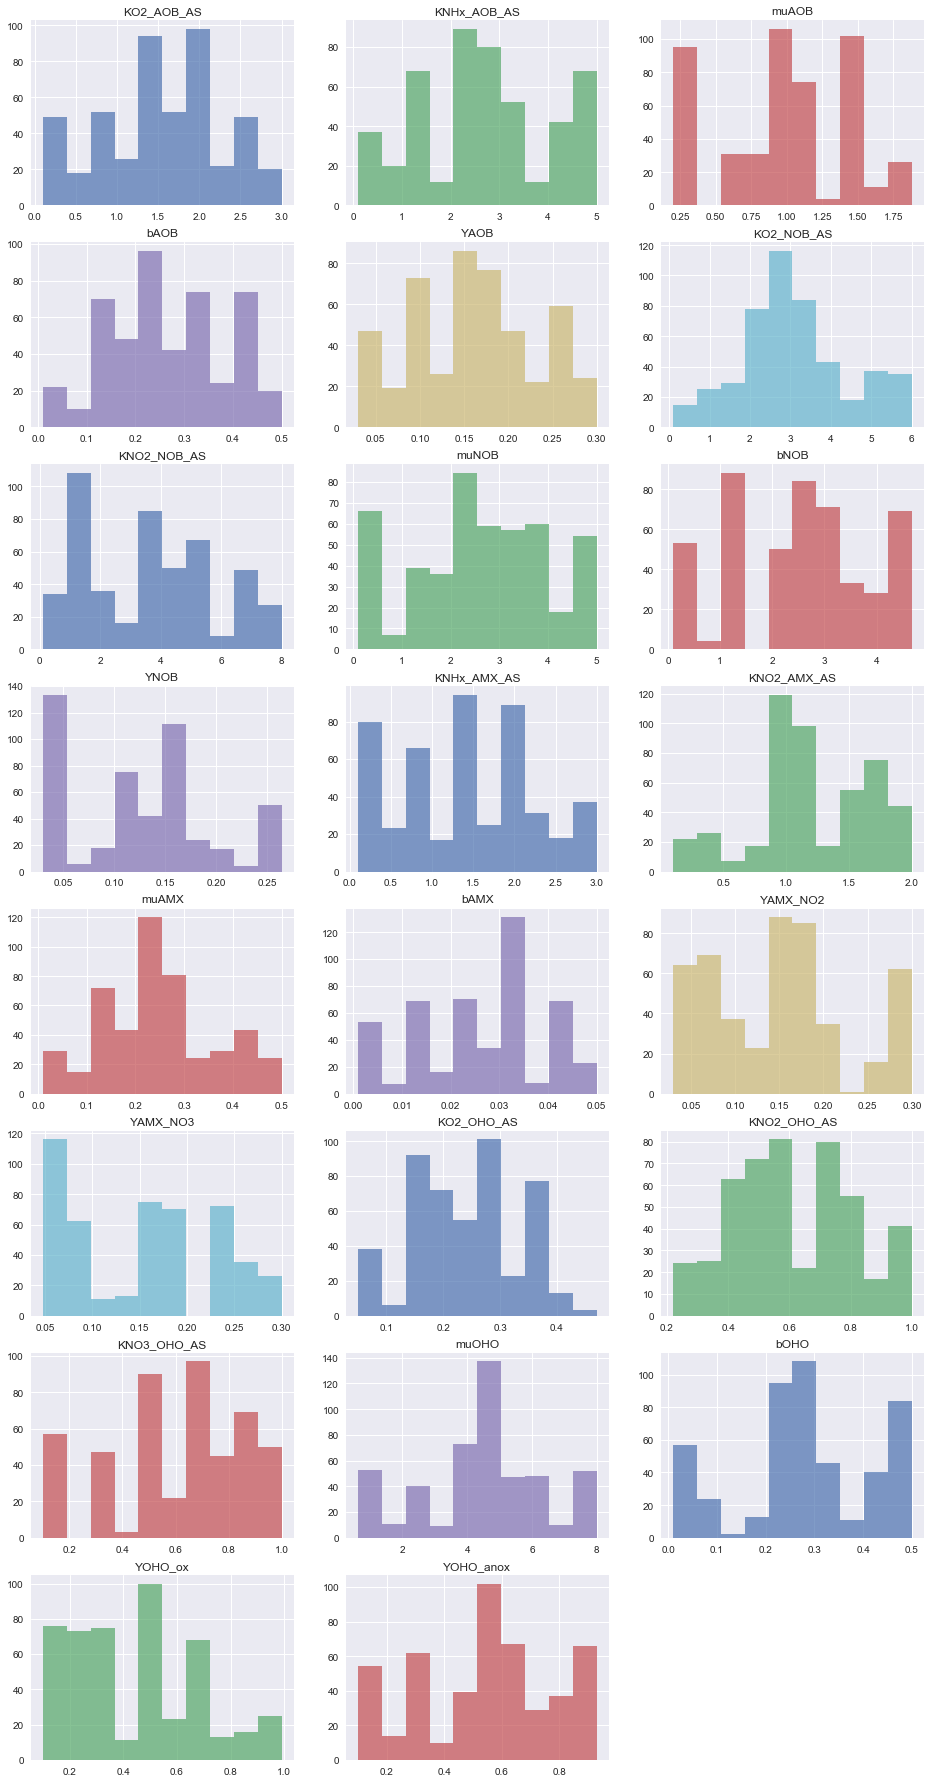

In [118]:
#selected_p=random.sample(param_values[:, 0].tolist(),3)
plt.figure(figsize=(16, 32))
cc=('C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C0','C1','C2','C3','C4','C5','C6','C7','C8','C9','C0', 'C1','C2')
for i in range(23):
    plt.subplot(8,3,i+1)
    plt.hist(param_values[:,i], histtype='stepfilled', alpha=0.7, color=cc[i] , bins=10)
    plt.title(problem['names'][i])
    #sns.rugplot(param_values[:,i],lw=2, color='#1C2833')

In [ ]:
param_values[0:5,:]

In [209]:
def converter(x): return ''.join(str(e) for e in 6*list(' '+ str(x)))
print(''.join(str(e) for e in 6*list(' '+ str(6.77))))
    
converter(4.5)
y=''.join(str(e) for e in 6*list(' '+ str(5.4)))
print(y)

 6.77 6.77 6.77 6.77 6.77 6.77
 5.4 5.4 5.4 5.4 5.4 5.4


### <a id=sensitivity></a> Start the sensitivity analysis

In [417]:
%%time
# Let's store all the sensitivity analysis results in one data structure.

from collections import OrderedDict
snhx_sensitivity_data = OrderedDict()
sno2_sensitivity_data = OrderedDict()
sno3_sensitivity_data = OrderedDict()

t_out=int(stop_t/dataComm)
iteration=param_values.shape[0]
set_cmd='set Sumo__Plant__Sumo2__'
param_names=problem['names']

for KNHx in [0.007, 0.7, 3.0, 5]:
    command = set_cmd+'KNHx_AOB_AS ' + str(KNHx) + ';'
                
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    print ('Iteration KNHx = ', KNHx)
    # Do not forget to empty our lists before a simulation, otherwise
    # new simulation results would just be appended.
    t = []
    snhx=[[] for i in range(6)]
    sno2=[[] for i in range(6)]
    sno3=[[] for i in range(6)]
    
    # Let's have Sumo do some work
    sumo.run_model()
    # The run_model is an asynchronous call, so we need to wait until
    # the current run is finished, otherwise we would mess up our simulations
    while not sumo.simulation_finished:
        time.sleep(0.01)

    # Good, we got our data in the list, let's store 'em in our dictionary, using 
    # KNHx as the label
    
    snhx_sensitivity_data[KNHx] = snhx[:t_out]
    sno2_sensitivity_data[KNHx] = sno2[:t_out]
    sno3_sensitivity_data[KNHx] = sno3[:t_out]

Iteration KNHx =  0.007
Iteration KNHx =  0.7
Iteration KNHx =  3.0
Iteration KNHx =  500
Wall time: 54.9 s


In [123]:
%%time
# Let's store all the sensitivity analysis results in one data structure.

from collections import OrderedDict
snhx_sensitivity_data = OrderedDict()
sno2_sensitivity_data = OrderedDict()
sno3_sensitivity_data = OrderedDict()

stop_t=12*3600*1000
dataComm = 180000
sumo.set_stopTime(stop_t)
sumo.set_dataComm(dataComm)

t_out=int(stop_t/dataComm)
iteration=param_values.shape[0]
set_cmd='set Sumo__Plant__Sumo2__'
param_names=problem['names']
for i in range(iteration):
    #k=random.randint(0,719)
    command=''
    for j in range(len(param_names)):
        command +=set_cmd + param_names[j] + ' '+ str(param_values[i,j]) + '; \n'
                
    sumo.core.csumo_command_send(sumo.handle, command.encode('utf8'))
    
    print ('Iteration ', i)
    # Do not forget to empty our lists before a simulation, otherwise
    # new simulation results would just be appended.
    t = []
    snhx=[[] for n in range(6)]
    sno2=[[] for n in range(6)]
    sno3=[[] for n in range(6)]
    
    # Let's have Sumo do some work
    sumo.run_model()
    # The run_model is an asynchronous call, so we need to wait until
    # the current run is finished, otherwise we would mess up our simulations
    while not sumo.simulation_finished:
        time.sleep(0.01)

    # Good, we got our data in the list, let's store 'em in our dictionary, using 
    # KNHx as the label
    
    snhx_sensitivity_data[i] = snhx
    sno2_sensitivity_data[i] = sno2
    sno3_sensitivity_data[i] = sno3

Iteration  0
Iteration  1
Iteration  2
Iteration  3
Iteration  4
Iteration  5
Iteration  6
Iteration  7
Iteration  8
Iteration  9
Iteration  10
Iteration  11
Iteration  12
Iteration  13
Iteration  14
Iteration  15
Iteration  16
Iteration  17
Iteration  18
Iteration  19
Iteration  20
Iteration  21
Iteration  22
Iteration  23
Iteration  24
Iteration  25
Iteration  26
Iteration  27
Iteration  28
Iteration  29
Iteration  30
Iteration  31
Iteration  32
Iteration  33
Iteration  34
Iteration  35
Iteration  36
Iteration  37
Iteration  38
Iteration  39
Iteration  40
Iteration  41
Iteration  42
Iteration  43
Iteration  44
Iteration  45
Iteration  46
Iteration  47
Iteration  48
Iteration  49
Iteration  50
Iteration  51
Iteration  52
Iteration  53
Iteration  54
Iteration  55
Iteration  56
Iteration  57
Iteration  58
Iteration  59
Iteration  60
Iteration  61
Iteration  62
Iteration  63
Iteration  64
Iteration  65
Iteration  66
Iteration  67
Iteration  68
Iteration  69
Iteration  70
Iteration  71
It

In [31]:
len(sno2_sensitivity_data.keys())

15

In [125]:
#Put the dictionary into a numpy array
from tempfile import TemporaryFile

snhx_sens_list=list(snhx_sensitivity_data.values())
sno2_sens_list=list(sno2_sensitivity_data.values())
sno3_sens_list=list(sno3_sensitivity_data.values())
#print(min(len(x) for x in sens_list))
snhx_sens_array=np.array(snhx_sens_list)
sno2_sens_array=np.array(sno2_sens_list)
sno3_sens_array=np.array(sno3_sens_list)

print ("snhx array dim ", snhx_sens_array.ndim)
print ("sno2 array dim ", sno2_sens_array.ndim)
print ("sno3 array dim ", sno3_sens_array.ndim)
print ("snhx array shape ", snhx_sens_array.shape)
print ("sno2 array shape ", snhx_sens_array.shape)

snhx array dim  3
sno2 array dim  3
sno3 array dim  3
snhx array shape  (480, 6, 241)
sno2 array shape  (480, 6, 241)


### Save simulation results to a text file

In [ ]:
with open('snhx_sens.txt','wb') as f:
    for a in snhx_sens_array:
        np.savetxt(f, a)
        f.write(b'\n')
        
with open('sno2_sens.txt','wb') as f:
    for a in sno2_sens_array:
        np.savetxt(f, a)
        f.write(b'\n')
        
with open('sno3_sens.txt','wb') as f:
    for a in sno3_sens_array:
        np.savetxt(f, a)
        f.write(b'\n')

### Load simulation result from the saved text file

In [40]:
snhx_array=np.loadtxt('snhx_sens.txt')
snhx_array=snhx_array.reshape(720,6,121)

### Plot simulation results

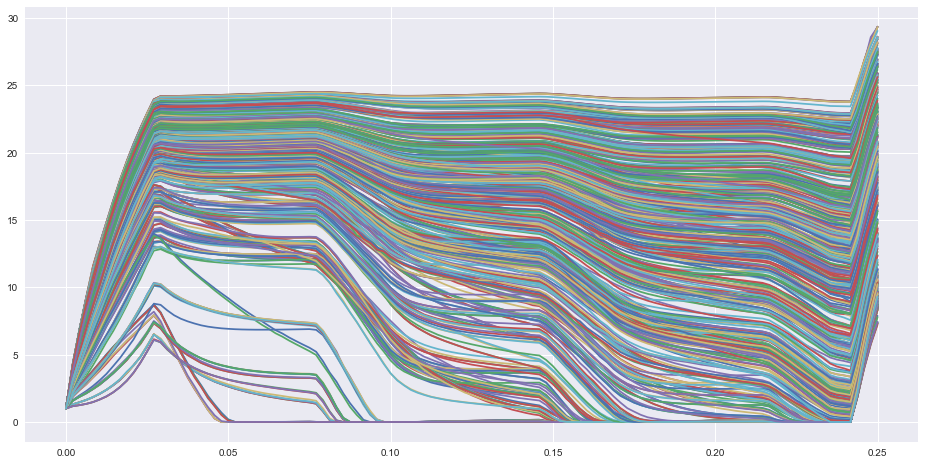

In [49]:
fig1=plt.figure(figsize=(16,8))
for i in range(720):
    plt.plot(t, snhx_array[i,0,:]) #ploting only the bulk layer concentration

<b> Alteratively we can plot the data using the direct simulation results </b>

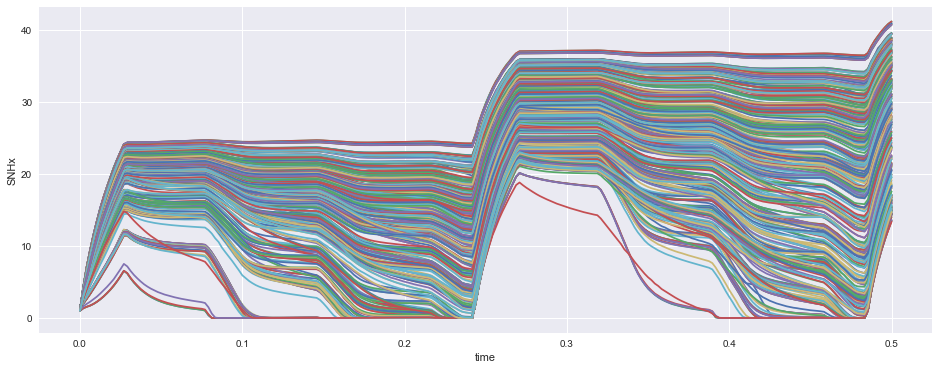

In [124]:
fig,ax=plt.subplots(1,1)
ax.set_xlabel('time')
ax.set_ylabel('SNHx')
titles=("Bulk", "Layer 1", "Layer 2", "Layer 3", "Layer 4", "Layer 5")
markers=('_','x','o','^')
fig.set_size_inches(16,6)
y_list=[]
for k, v in snhx_sensitivity_data.items():
    
    ax.plot(t, v[0], label=str(k))
    y_list.append(v[0])

#plt.legend(loc='upper right', title='Legend')


In [ ]:
#Converting the array to pandas dataframe for the bulk layer
snhx_layer0=snhx_sens_array[:,0,:]
print(snhx_layer0.shape)
snhx_layer0df= pd.DataFrame(snhx_layer0.T)
snhx_layer0df.head(10)

### Ploting results using bokeh library for better visualization

In [ ]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import named
from bokeh.palettes import d3
output_notebook()
clrs=d3['Category20'][20]
i=0
# create a new plot with a title and axis labels
p = figure(plot_width=800, plot_height=400, title="Ammonium concentration", x_axis_label='time, day', y_axis_label='mg-N/L')
for k, v in snhx_sensitivity_data.items():
    if i > 19:
        i=0

    p.line(t, v[0], legend=str(k), color=clrs[i], line_width=2 )
    i +=1
# show the results
show(p)

In [ ]:
X=np.array(list(snhx_sensitivity_data.keys()))
Y=np.array(y_list)
corr=[]
#np.corrcoef(X,Y[:,-1])
for i in range(Y.shape[1]):
    corr.append(stats.pearsonr(X,Y[:,i])[0])
    


In [199]:
plt.plot(t, corr, 'ro')
plt.show()

### <span style="color:IndianRed">Start calculating the sensitivity indices</span>

In [128]:
Si=[]
Si_list_dict=[]
X=param_values
Y=snhx_sens_array[:,0,:]
print("X size ", X.shape)
print(Y.shape)
#array to hold sensitivity results at each time step
Si_ndarray=np.empty([4,23,241])

X size  (480, 23)
(480, 241)


In [129]:
%%time
#Conduct the sensitivty analysis using morris method from SALib.morris package
for i in range(241):
    Y=snhx_sens_array[:,0,i]
    Si_out=mr.analyze(problem, X, Y, conf_level=0.95, print_to_console=False, num_levels=16, grid_jump=6)   
    Si_list_dict.append(Si_out)
    Si_list=list(Si_out.values())
    Si_array=np.array(Si_list)
    Si.append(Si_list)
    Si_ndarray[:,:,i]=Si_array[1:,:,]
    

Wall time: 3.33 s


### Plot the sensitivity indices

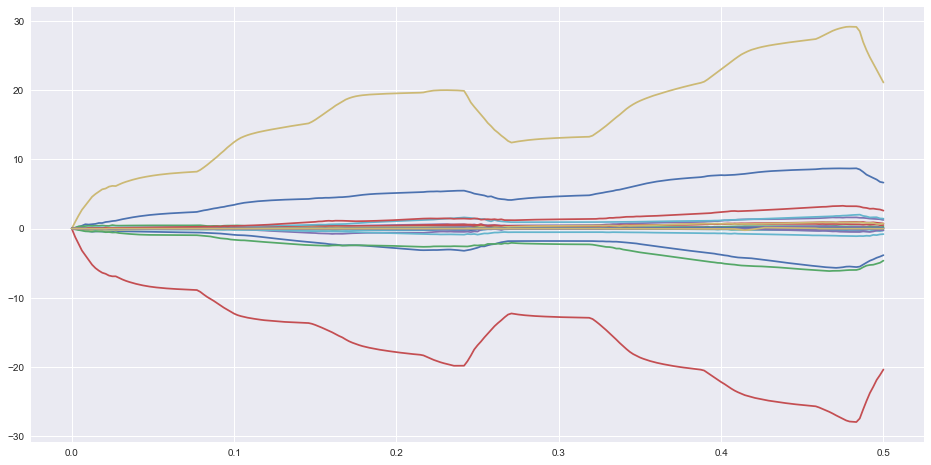

In [130]:
#Plot mu values
fig=plt.figure(figsize=(16,8))
for i in range(23):
    plt.plot(t, Si_ndarray[0,i,:])

### Filter the important parameters based on a threshold

In [131]:
from itertools import compress
sens_treshold=3
sens_filter=[max(Si_ndarray[1,i,:])>sens_treshold for i in range(23)]
#Filter the array
Si_filtered_array=Si_ndarray[1,sens_filter,:]
#Filter the parameters list
filtered_params= list(compress(Si_list[0], sens_filter))

filtered_params

['KO2_AOB_AS', 'muAOB', 'YAOB', 'muAMX', 'muOHO', 'bOHO']

In [132]:
from bokeh.plotting import figure, output_file, show
from bokeh.io import output_notebook
from bokeh.colors import named
from bokeh.palettes import d3
output_notebook()

Loading BokehJS ...

In [133]:
clrs=d3['Category20'][20]
i=0
# create a new plot with a title and axis labels
p = figure(plot_width=800, plot_height=500, title="EE sensitivity indices", x_axis_label='time, day', y_axis_label='EE')
for i in range(sens_filter.count(True)):
    if i > 19:
        i=0
    p.line(t, Si_filtered_array[i,:], legend=filtered_params[i], color=clrs[i], line_width=2 )
    i +=1
# show the results
show(p)

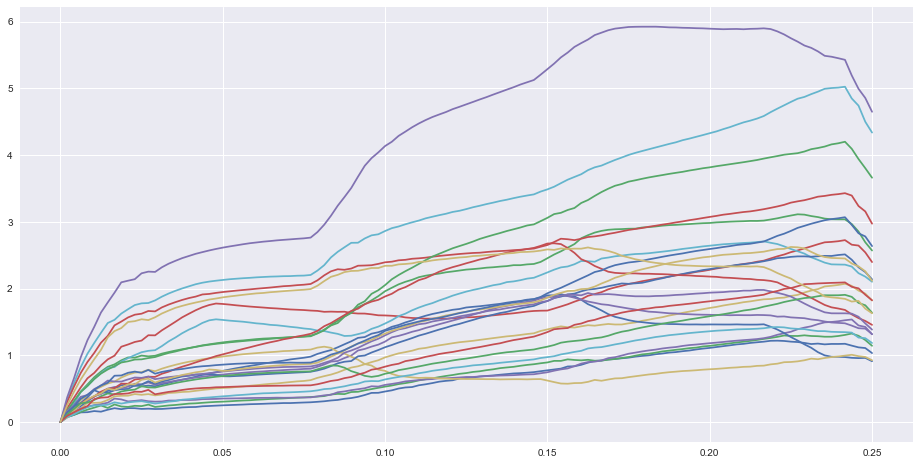

In [65]:
#Plot mu* |mu| values
fig=plt.figure(figsize=(16,8))
for i in range(23):
    plt.plot(t, Si_ndarray[1,i,:])

(200, 2)


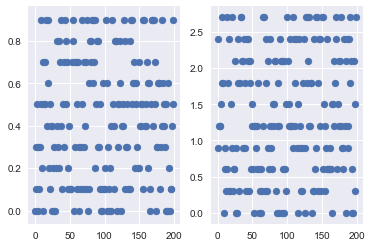

In [159]:
samp=np.random.randint(10, size=(200,2))
delta=[0.1,0.3]
newarr=samp*delta
print(newarr.shape)
xa=np.arange(200)
plt.subplot(121)
plt.scatter(xa, newarr[:,0])
plt.subplot(122)
plt.scatter(xa, newarr[:,1])


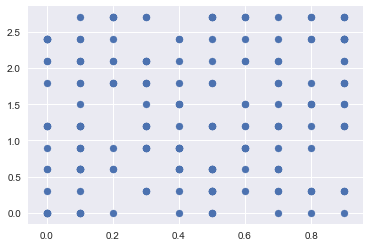

In [160]:
plt.scatter(newarr[:,0],newarr[:,1])